In [52]:
from scipy.optimize import nnls
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF

from random import sample

from functions import cosine_perm, simulate_counts, cosine_max
from AAUtoSig_init import AAUtoSig, train_AAUtoSig
import torch

## Split data
Firstly we write a method to split the mutational profile matrix into a training and validation set.

In [53]:
def split_data(data, frac_1):
  x_train = data.sample(frac = frac_1)
  x_validation = data.drop(x_train.index)
  return x_train, x_validation

# NMF performance

In [54]:
def out_errorNMF(train_df, validation_df, nsigs ,true_sigs, max = False):
  model = NMF(n_components=nsigs, init='random', max_iter = 500)
  exposures = model.fit_transform(train_df)
  signatures = model.components_

  ref_exposures = model.transform(X = validation_df)
  rec = np.dot(ref_exposures, signatures)
  MSE = np.mean(((validation_df - rec)**2).to_numpy())

  if max == True:
    cos_max = cosine_max(signatures, true_sigs.to_numpy().T)
    return cos_max, MSE
  else:
    cos_NMF = cosine_perm(true_sigs.to_numpy().T, signatures)[0]
    cos_mean = np.mean(cos_NMF.diagonal())
    return cos_mean, MSE

# AAUtoSig performance

In [55]:
def out_error_AAUtoSig(train_df, validation_df, nsigs,true_sigs, max = False):
    model = AAUtoSig(nsigs)

    # Validation using MSE Loss function
    loss = torch.nn.MSELoss(reduction='mean')

     # Using an Adam Optimizer with lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(),
                            lr = 1e-3)
    train_AAUtoSig(500, model, train_df, loss_function= loss, optimizer=optimizer, batch_size= 32)

    signatures = model.dec1.weight.data    
    signatures = pd.DataFrame(signatures.numpy())

    def calculate_exp(b):
       return(nnls(A = signatures, b = b)[0])
   
    ref_exposures = np.stack(validation_df.apply(calculate_exp, axis = 1))
    rec = np.dot(ref_exposures, signatures.T)

    MSE = np.mean(((validation_df - rec)**2).to_numpy())
    #return(MSE)
    if max == True:
       cos_max = cosine_max(signatures.T, true_sigs.to_numpy().T)
       return cos_max, MSE
    else:
       asd = cosine_perm(true_sigs.to_numpy().T, signatures.T)
       cos_Deep = asd[0]
       cos_mean = np.mean(cos_Deep.diagonal())
      
       return cos_mean, MSE

## Performance analysis

In [56]:
def performance_analysis(npatients, nsigs):
  mut_matrix_l, signatures_l, _ = simulate_counts(nsigs, npatients)
  train_data_l, validation_data_l = split_data(mut_matrix_l.T, 0.8)
  cosineNMF_perm, outNMF = out_errorNMF(train_data_l, validation_data_l, nsigs, signatures_l)
  cosineAE_perm, outAE = out_error_AAUtoSig(train_data_l, validation_data_l, nsigs, signatures_l)
  return [cosineNMF_perm, outNMF, cosineAE_perm, outAE]
asd = [performance_analysis(2000, 12) for _ in range(2)] 
result = pd.DataFrame(asd)
result.columns = ["cosineNMF_perm", "outNMF", "cosineAE_perm", "outAE"]


KeyboardInterrupt: 

In [57]:
def performance_analysis(npatients, nsigs):
  mut_matrix_l, signatures_l, _ = simulate_counts(nsigs, npatients)
  train_data_l, validation_data_l = split_data(mut_matrix_l.T, 0.8)
  cosineNMF_max, outNMF = out_errorNMF(train_data_l, validation_data_l, nsigs, signatures_l, max = True)
  cosineAE_max, outAE = out_error_AAUtoSig(train_data_l, validation_data_l, nsigs, signatures_l, max = True)
  return [cosineNMF_max, outNMF, cosineAE_max, outAE]
asd = [performance_analysis(2000, 12) for _ in range(2)] 
result = pd.DataFrame(asd)
result.columns = ["cosineNMF_max", "outNMF", "cosineAE_max", "outAE"]


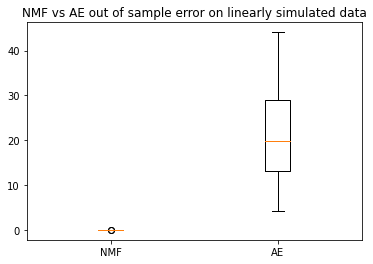

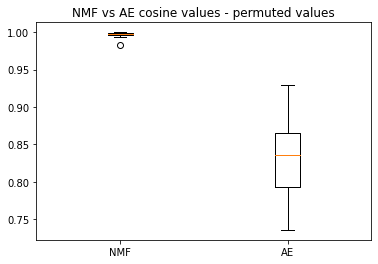

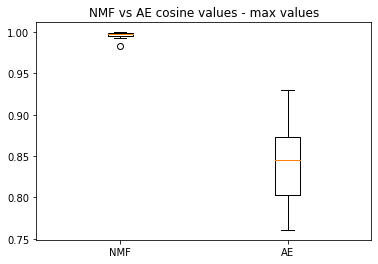

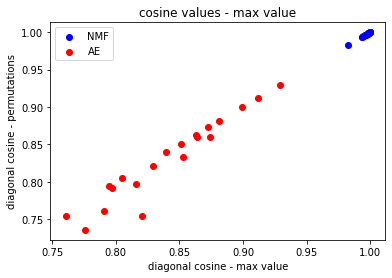

In [30]:
plt.boxplot(result[['outNMF', 'outAE']], labels = ["NMF", "AE"])
plt.title('NMF vs AE out of sample error on linearly simulated data')
plt.show()

plt.boxplot(result[['cosineNMF_perm', 'cosineAE_perm']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values - permuted values')
plt.show()

plt.boxplot(result[['cosineNMF_max', 'cosineAE_max']] ,labels = ["NMF", "AE"])
plt.title('NMF vs AE cosine values - max values')
plt.show()


plt.scatter(y = result['cosineNMF_perm'], x = result['cosineNMF_max'], c = 'blue', label = 'NMF')
plt.scatter(y = result['cosineAE_perm'], x = result['cosineAE_max'], c = 'red', label = 'AE')
plt.xlabel('diagonal cosine - max value')
plt.ylabel('diagonal cosine - permutations')
plt.title('cosine values - max value')
plt.legend()
plt.show()
#plt.savefig('linear.png', transparent=True)
